In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
import shap
shap.initjs()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_init = pd.read_csv('data.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_109,Feature_110,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118
0,1,2,2,56,12,1,7.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,1,1,0
1,2,2,2,69,19,1,6.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,1
2,3,2,1,66,8,1,4.0,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0
3,4,2,2,62,16,1,NaN,3,0,1.0,...,1.0,0.0,1,0,1,1,0,0,1,1
4,5,2,2,67,30,1,NaN,4,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0


In [3]:
def train(df, trash_features = []):

    df_ = df.copy()

    target_feature = 'Result'

    usefull_features = []

    useless_features = ['Id', 'Feature_4', 'Feature_5', 'Feature_17', 'Feature_18', 'Feature_23', 'Feature_32', 
                        'Feature_35', 'Feature_54', 'Feature_94', 'Feature_101', 'Feature_108', 
                        'Feature_116', 'Feature_117']

    features_to_drop = [target_feature] + useless_features
    for feature in trash_features:
        if feature not in usefull_features and feature not in useless_features:
            features_to_drop.append(feature)

    all_features = df_.columns.drop(features_to_drop).tolist()

    df_ = df_[[target_feature] + all_features]

    num_features = ['Feature_3', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 
                    'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 
                    'Feature_53', 'Feature_55', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 
                    'Feature_71', 'Feature_72', 'Feature_73']
    
    special_features = ['Feature_17', 'Feature_18', 'Feature_23', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 
                        'Feature_78', 'Feature_79', 'Feature_80', 'Feature_81', 'Feature_82', 'Feature_83', 'Feature_84', 
                        'Feature_85', 'Feature_86', 'Feature_87', 'Feature_88', 'Feature_89', 'Feature_90', 'Feature_91', 
                        'Feature_92', 'Feature_93', 'Feature_94', 'Feature_95', 'Feature_96', 'Feature_97', 'Feature_98', 
                        'Feature_99', 'Feature_100']
    
    for col in special_features:
        if col in df_.columns:
            df_[col].fillna(0, inplace=True)

    cat_features = []
    for col in df_.drop(target_feature, axis=1).columns:
        if col in num_features:
            df_[col].fillna(df_[col].median(), inplace=True)
            df_[col] = df_[col].astype('float64')
        else:
            cat_features.append(col)
            df_[col].fillna(-1, inplace=True)
            df_[col] = df_[col].astype('int64')
    
    # Result=0 - alive, Result=1 died
    df_.loc[df_[target_feature] == 1, target_feature] = 0
    df_.loc[df_[target_feature] == 2, target_feature] = 1

    X = df_[all_features]
    y = df_[target_feature]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=True,
        test_size=0.25,
        random_state=0,
        stratify=y,
    )

    train_pool = Pool(
        X_train,
        y_train,
        cat_features=cat_features
    )

    params_frozen = {
        'eval_metric': 'Accuracy',
        'early_stopping_rounds': 50,
        # 'first_feature_use_penalties': [0.1],
    }

    params_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'iterations': [100, 200, 400, 600, 800, 1000, 1200],
        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
        'bagging_temperature': [1, 1.5, 2, 2.5],
    }

    clf = CatBoostClassifier(**params_frozen)
    rs = clf.randomized_search(
        params_grid,
        train_pool,
        n_iter=5,
        shuffle=True,
        stratified=True,
        partition_random_seed=0,
        cv=5,
        calc_cv_statistics=True,
        search_by_train_test_split=False,
        refit=True,
    )

    return clf, df_, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature

In [4]:
trash_features = []
epochs = 5
for epoch in range(1, epochs+1):

    print(f"\nEpoch {epoch} from {epochs}\n{'=' * 50}")

    clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
        df_init,
        trash_features=trash_features,
    )

    test_pool = Pool(
        X_test,
        y_test,
        cat_features=cat_features
    )
    y_test_pred = clf.predict(test_pool)

    print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
    print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

    feature_importances = pd.DataFrame(
        zip(X_train.columns, clf.get_feature_importance()),
        columns=['feature_name', 'importance']
    )

    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    features = feature_importances[feature_importances['importance'] < 1 ]['feature_name'].tolist()
    if len(trash_features) > 0:
        for feature in features:
            if feature not in trash_features:
                trash_features.append(feature)
    else:
        trash_features=features

    print('Fetures to drop')
    print(trash_features)


Epoch 1 from 5
Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.8478355	best: 0.8478355 (0)	total: 39.3s	remaining: 2m 37s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.8577922	best: 0.8577922 (1)	total: 2m 14s	remaining: 3m 21s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.8959740	best: 0.8959740 (2)	total: 2m 55s	remaining: 1m 56s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.8573593	best: 0.8959740 (2)	total: 4m 38s	remaining: 1m 9s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.8123810	best: 0.8959740 (2)	total: 6m 11s	remaining: 0us
Accuracy: 0.86
F1 Score: 0.9

Classification report: 
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.92      0.88      0.90        25

    accuracy                           0.86        36
   macro avg       0.83      0.85      0.84        36
weighted avg       0.87      0.86     

In [5]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

for feature in feature_importances[15:]['feature_name'].tolist():
    if feature not in trash_features:
        trash_features.append(feature)

In [6]:
clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
    df_init,
    trash_features=trash_features,
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features
)
y_test_pred = clf.predict(test_pool)
y_test_pred_proba = clf.predict_proba(test_pool)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.8868831	best: 0.8868831 (0)	total: 23.2s	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.8964069	best: 0.8964069 (1)	total: 45.1s	remaining: 1m 7s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.9059740	best: 0.9059740 (2)	total: 1m 1s	remaining: 41s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.8868831	best: 0.9059740 (2)	total: 1m 36s	remaining: 24.2s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.8778355	best: 0.9059740 (2)	total: 2m 10s	remaining: 0us
Accuracy: 0.92
F1 Score: 0.94

Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.96      0.92      0.94        25

    accuracy                           0.92        36
   macro avg       0.90      0.91      0.90        36
weighted avg       0.92      0.92      0.92        36



In [7]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
0,Feature_3,30.859968
5,Feature_34,14.855034
3,Feature_29,10.425223
12,Feature_70,5.943414
14,Feature_99,5.756984
8,Feature_47,4.865823
11,Feature_56,4.502961
6,Feature_41,4.327882
2,Feature_9,4.124769
9,Feature_51,3.188297


In [8]:
explainer = shap.TreeExplainer(clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

## Важность признаков при оценке через числа Шепли

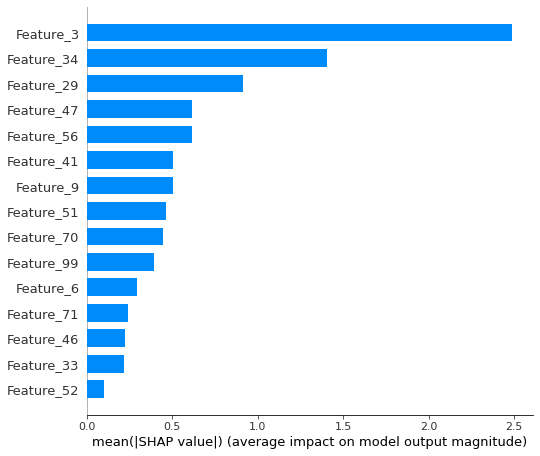

In [10]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar", max_display=40)

## Число Шепли / Признаки

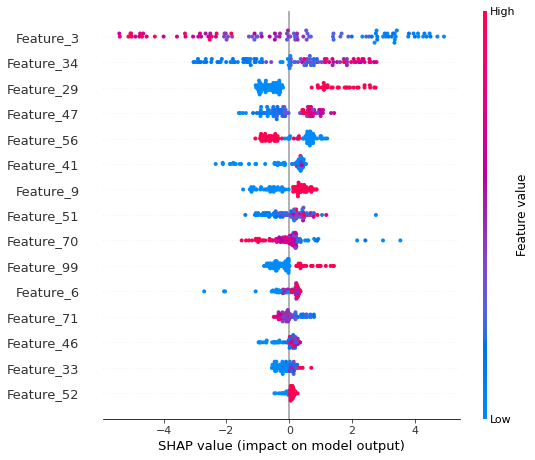

In [9]:
shap.summary_plot(shap_values_train, X_train, max_display=40)

## Анализ возможного пограничного значения на примере признака #47

In [96]:
df_border_value_47 = pd.DataFrame()
df_border_value_47['Feature_47'] = X_train.iloc[:,8]
df_border_value_47['Result_true'] = y_train
df_border_value_47.head()

,Feature_47,Result_true
120,6.0,0
83,4.9,1
18,10.8,1
136,5.1,0
128,7.0,0


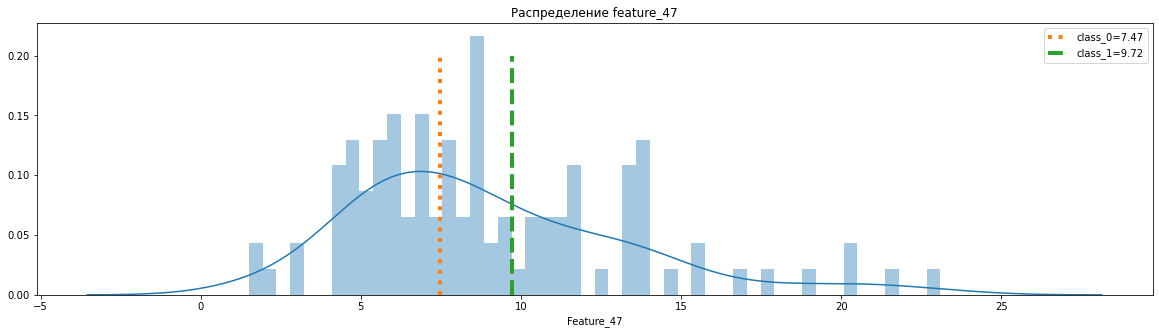

In [97]:
feature_47_class_0 = round(df_border_value_47[df_border_value_47['Result_true'] == 0]['Feature_47'].mean(), 2)
feature_47_class_1 = round(df_border_value_47[df_border_value_47['Result_true'] == 1]['Feature_47'].mean(), 2)

plt.figure(figsize = (20, 5))

sns.distplot(df_border_value_47['Feature_47'], bins=50)

y = np.linspace(0, 0.20, 10)
plt.plot([feature_47_class_0] * 10, y, label=f'class_0={feature_47_class_0}', linestyle=':',  linewidth=4)
plt.plot([feature_47_class_1] * 10, y, label=f'class_1={feature_47_class_1}', linestyle='--',  linewidth=4)

plt.title('Распределение feature_47')
plt.legend()

### Среднее значение Feature_47 для исхода 0 =7.47, для исхода 1 - 9.72

## Тестовый датасет

### Добавленные колонки

* Result_true	- исход в исходных данных
* Result_pred	 - исход предсказанный
* Result_pred_proba - вероятность, с которой предсказан первый класс

In [11]:
df_explain_table = X_test.copy()
df_explain = X_test.copy()

df_explain_table['Result_true'] = y_test
df_explain_table['Result_pred'] = y_test_pred
df_explain_table['Result_pred_proba'] = y_test_pred_proba[:, 1:2]

## Наблюдения из тестового датасета, на которых модель ошибается

In [12]:
df_errors = df_explain_table[df_explain_table['Result_true'] != df_explain_table['Result_pred']]
df_errors.T

,36,57,104
Feature_3,10.000000,14.000000,34.00000
Feature_6,4.000000,2.000000,3.00000
Feature_9,0.000000,0.000000,1.00000
Feature_29,0.000000,0.000000,1.00000
Feature_33,4.000000,2.000000,5.00000
Feature_34,7.000000,11.000000,9.00000
Feature_41,0.020000,0.010000,0.08000
Feature_46,178.410000,267.000000,48.95000
Feature_47,5.200000,6.300000,6.20000
Feature_51,70.570000,66.000000,231.00000


### в исходной таблице #37, #58, #105